# Taller de búsqueda de hiperparámetros

En este taller vamos a explorar la búsqueda de hiperparámetros de manera automática.

In [1]:
import time
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
X, y = load_breast_cancer(return_X_y=True)

In [3]:
test_size=0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

**Ejemplo 1:** encuentra los mejores hiperparámetros usando `GridSearchCV`

In [4]:
clf = DecisionTreeClassifier()

# define los valores que usarás en la búsqueda del
# hiperparametro C
param_grid = {
    "max_depth": (3, 6, 12, 18),
    "min_samples_leaf": (1, 2, 3),
    "criterion": ["gini", "entropy"]
}

# Utiliza GridSearchCV
gs = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

t0 = time.time()
gs.fit(X_train, y_train)
print("Tiempo de búsqueda: {:.3f}s".format(time.time() - t0))

Tiempo de búsqueda: 0.492s


podemos ver que el atributo `cv_results_` nos entrega los resultados de toda la búsqueda.

In [5]:
dir(gs)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_refit_for_multimetric',
 '_check_scorers_accept_sample_weight',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_format_results',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params_html',
 '_get_routed_params_for_fit',
 '_get_scorers',
 '_html_repr',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_run_sea

In [6]:
gs.cv_results_

{'mean_fit_time': array([0.00265336, 0.00260329, 0.0025074 , 0.00360274, 0.00327516,
        0.00330825, 0.00380311, 0.00310721, 0.00300813, 0.00371499,
        0.00371342, 0.00320268, 0.00359859, 0.00340276, 0.00361004,
        0.00371332, 0.00380316, 0.00390263, 0.00420995, 0.00386381,
        0.0037096 , 0.00373583, 0.00360789, 0.00400963]),
 'std_fit_time': array([0.00078454, 0.00058586, 0.00045477, 0.00058393, 0.00072546,
        0.00040556, 0.00051023, 0.00019847, 0.00030581, 0.00051297,
        0.00059821, 0.00024947, 0.00062421, 0.00037502, 0.00058507,
        0.0003849 , 0.00051015, 0.00051911, 0.00068685, 0.00076502,
        0.00050178, 0.00041096, 0.00057858, 0.00071194]),
 'mean_score_time': array([0.00040002, 0.00020008, 0.00060081, 0.00060058, 0.0003346 ,
        0.00020013, 0.00050111, 0.00059996, 0.00060081, 0.00040083,
        0.00030103, 0.00059981, 0.00019937, 0.00039997, 0.00020003,
        0.00080299, 0.00059977, 0.00040002, 0.00019956, 0.00040016,
        0.000399

Lo más importante es extraer los hiperparámetros del modelo que mejor error en de validación sacaron

In [7]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1}

También es posible el mejor resultado en la métrica usada

In [8]:
gs.best_score_

np.float64(0.9483173734610124)

Finalmente, es posible extraer directamente un estimador que que ha sido creado con los mejores hiperparámetros.

In [9]:
gs.best_estimator_

,criterion,'entropy'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


**Ejemplo 2:** la clase `RandomizedSearchCV` se puede usar casi de la misma manera, solo que esta vez se debe escoger un número de combinaciones a evaluar; las cuales se escogeran de manera aleatoria.

In [10]:
clf = DecisionTreeClassifier()

# define los valores que usarás en la búsqueda del
# hiperparametro C
param_dist = {
    "max_depth": (3, 6, 12, 18),
    "min_samples_leaf": (1, 2, 3),
    "criterion": ["gini", "entropy"]
}

# Utiliza RandomizedSearchCV
rs = RandomizedSearchCV(clf, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

t0 = time.time()
rs.fit(X_train, y_train)
print("Tiempo de búsqueda: {:.3f}s".format(time.time() - t0))

Tiempo de búsqueda: 0.202s


In [11]:
rs.best_score_

np.float64(0.93187414500684)

Podemos ver que aunque se demoró mucho menos, el resultado no es tan bueno.

# Búsqueda de hiperparámetros con Optuna (Versión Mejorada)

In [12]:
# Importar librerías necesarias
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# Verificar el desbalance de clases
print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"   Clase 0: {np.bincount(y_train)[0]} muestras")
print(f"   Clase 1: {np.bincount(y_train)[1]} muestras")
print(f"   Ratio: {np.bincount(y_train)[1]/np.bincount(y_train)[0]:.2f}")

f:\Universidad\Aprendizaje automático\Hw\Tareas-Aprendizaje-Automatico\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Distribución de clases en entrenamiento: [159 267]
   Clase 0: 159 muestras
   Clase 1: 267 muestras
   Ratio: 1.68


In [13]:
def objective(trial):
    """
    Función objetivo para Optuna
    """
    # Hiperparámetros básicos (como en los ejemplos anteriores)
    max_depth = trial.suggest_categorical('max_depth', [3, 6, 12, 18])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 3])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8])
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.01, step=0.001)
    
    # Crear el clasificador con todos los hiperparámetros
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        min_samples_split=min_samples_split,
        max_features=max_features,
        ccp_alpha=ccp_alpha,
        random_state=42  # Para reproducibilidad
    )
    
    # Validación cruzada estratificada (mejor que la normal para datos desbalanceados)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calcular múltiples métricas
    f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=skf)
    accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=skf)
    
    # Métrica principal: F1-score (por el desbalance)
    f1_mean = f1_scores.mean()
    
    # Guardar métricas adicionales como atributos del trial
    trial.set_user_attr('f1_std', f1_scores.std())
    trial.set_user_attr('accuracy_mean', accuracy_scores.mean())
    trial.set_user_attr('accuracy_std', accuracy_scores.std())
    trial.set_user_attr('f1_scores', f1_scores.tolist())
    
    return f1_mean

In [14]:
# Crear estudio de Optuna con configuración avanzada
study_enhanced = optuna.create_study(
    direction='maximize',  # Maximizar F1-score
    sampler=TPESampler(seed=42, n_startup_trials=10),  # Más trials antes de usar TPE
    pruner=MedianPruner(
        n_startup_trials=5, 
        n_warmup_steps=10,
        interval_steps=1
    ),  # Pruning más agresivo
    study_name="DecisionTree_Enhanced_Hyperparameter_Search"
)

print("Configuración:")
print(f"   Dirección: {study_enhanced.direction}")
print(f"   Sampler: {study_enhanced.sampler.__class__.__name__}")
print(f"   Pruner: {study_enhanced.pruner.__class__.__name__}")
print(f"   Startup trials: 10 (vs 5 por defecto)")

# Ejecutar la optimización con más trials
n_trials = 100
print(f"\nIniciando optimización con {n_trials} trials...")
print("="*60)

t0 = time.time()
study_enhanced.optimize(
    objective, 
    n_trials=n_trials,
    show_progress_bar=True,  # Barra de progreso
    callbacks=[lambda study, trial: print(f"Trial {trial.number}: {trial.value:.4f}")
               if trial.number % 10 == 0 else None]  # Progreso cada 10 trials
)
optimization_time = time.time() - t0

print(f"\nTiempo de búsqueda: {optimization_time:.3f}s")
print(f"Trials completados: {len([t for t in study_enhanced.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Trials probados: {len([t for t in study_enhanced.trials if t.state == optuna.trial.TrialState.PRUNED])}")

# Mostrar resultados
print("\n" + "="*60)
print("MEJORES RESULTADOS - OPTUNA")
print("="*60)
print(f"Mejor F1-score: {study_enhanced.best_value:.6f}")
print(f"Mejores hiperparámetros:")
for param, value in study_enhanced.best_params.items():
    print(f"   {param}: {value}")

# Mostrar métricas adicionales del mejor trial
best_trial = study_enhanced.best_trial
print(f"\nMétricas adicionales del mejor trial:")
print(f"   F1 std: {best_trial.user_attrs.get('f1_std', 'N/A'):.4f}")
print(f"   Accuracy mean: {best_trial.user_attrs.get('accuracy_mean', 'N/A'):.4f}")
print(f"   Accuracy std: {best_trial.user_attrs.get('accuracy_std', 'N/A'):.4f}")

[I 2025-07-13 23:23:01,028] A new study created in memory with name: DecisionTree_Enhanced_Hyperparameter_Search


Configuración:
   Dirección: 2
   Sampler: TPESampler
   Pruner: MedianPruner
   Startup trials: 10 (vs 5 por defecto)

Iniciando optimización con 100 trials...


Best trial: 0. Best value: 0.943973:   4%|▍         | 4/100 [00:00<00:03, 28.58it/s]

[I 2025-07-13 23:23:01,054] Trial 0 finished with value: 0.9439727340021611 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 15, 'max_features': 'log2', 'ccp_alpha': 0.002}. Best is trial 0 with value: 0.9439727340021611.
Trial 0: 0.9440
[I 2025-07-13 23:23:01,103] Trial 1 finished with value: 0.9382117439390422 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'entropy', 'min_samples_split': 16, 'max_features': 0.8, 'ccp_alpha': 0.001}. Best is trial 0 with value: 0.9439727340021611.
[I 2025-07-13 23:23:01,127] Trial 2 finished with value: 0.936702763056814 and parameters: {'max_depth': 12, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 11, 'max_features': 'log2', 'ccp_alpha': 0.005}. Best is trial 0 with value: 0.9439727340021611.
[I 2025-07-13 23:23:01,168] Trial 3 finished with value: 0.9366722476985704 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_spli

Best trial: 0. Best value: 0.943973:   4%|▍         | 4/100 [00:00<00:03, 28.58it/s]

[I 2025-07-13 23:23:01,217] Trial 4 finished with value: 0.9271630170384351 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 17, 'max_features': None, 'ccp_alpha': 0.001}. Best is trial 0 with value: 0.9439727340021611.


Best trial: 0. Best value: 0.943973:   9%|▉         | 9/100 [00:00<00:03, 27.14it/s]

[I 2025-07-13 23:23:01,261] Trial 5 finished with value: 0.9399489686380887 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 10, 'max_features': 0.8, 'ccp_alpha': 0.005}. Best is trial 0 with value: 0.9439727340021611.
[I 2025-07-13 23:23:01,284] Trial 6 finished with value: 0.9328680627311519 and parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'criterion': 'entropy', 'min_samples_split': 6, 'max_features': 'log2', 'ccp_alpha': 0.001}. Best is trial 0 with value: 0.9439727340021611.
[I 2025-07-13 23:23:01,329] Trial 7 finished with value: 0.9399489686380887 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 19, 'max_features': 0.8, 'ccp_alpha': 0.009000000000000001}. Best is trial 0 with value: 0.9439727340021611.
[I 2025-07-13 23:23:01,354] Trial 8 finished with value: 0.933771183447923 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_sp

Best trial: 10. Best value: 0.944839:  11%|█         | 11/100 [00:00<00:03, 28.36it/s]

[I 2025-07-13 23:23:01,419] Trial 10 finished with value: 0.9448387346412194 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 2, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 10 with value: 0.9448387346412194.
Trial 10: 0.9448


Best trial: 14. Best value: 0.949556:  14%|█▍        | 14/100 [00:00<00:03, 26.93it/s]

[I 2025-07-13 23:23:01,459] Trial 11 finished with value: 0.9448387346412194 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 2, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 10 with value: 0.9448387346412194.
[I 2025-07-13 23:23:01,501] Trial 12 finished with value: 0.9448387346412194 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 2, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 10 with value: 0.9448387346412194.
[I 2025-07-13 23:23:01,541] Trial 13 finished with value: 0.9448387346412194 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 2, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 10 with value: 0.9448387346412194.
[I 2025-07-13 23:23:01,583] Trial 14 finished with value: 0.9495564245088219 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 6, 'max_features'

Best trial: 15. Best value: 0.951184:  15%|█▌        | 15/100 [00:00<00:03, 26.93it/s]

[I 2025-07-13 23:23:01,624] Trial 15 finished with value: 0.9511842376945532 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.


Best trial: 15. Best value: 0.951184:  20%|██        | 20/100 [00:00<00:03, 25.29it/s]

[I 2025-07-13 23:23:01,664] Trial 16 finished with value: 0.9459912309436446 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:01,719] Trial 17 finished with value: 0.93904118899446 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 8, 'max_features': None, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:01,749] Trial 18 finished with value: 0.9393992335815196 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': 'sqrt', 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:01,790] Trial 19 finished with value: 0.935263388457859 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 

Best trial: 15. Best value: 0.951184:  20%|██        | 20/100 [00:00<00:03, 25.29it/s]

[I 2025-07-13 23:23:01,831] Trial 20 finished with value: 0.9404656244105786 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 9, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
Trial 20: 0.9405


Best trial: 15. Best value: 0.951184:  24%|██▍       | 24/100 [00:00<00:03, 24.97it/s]

[I 2025-07-13 23:23:01,873] Trial 21 finished with value: 0.9459912309436446 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:01,914] Trial 22 finished with value: 0.9472604695292255 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:01,955] Trial 23 finished with value: 0.9472604695292255 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:01,995] Trial 24 finished with value: 0.9472604695292255 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 4, 'max_feature

Best trial: 15. Best value: 0.951184:  26%|██▌       | 26/100 [00:00<00:02, 25.47it/s]

[I 2025-07-13 23:23:02,026] Trial 25 finished with value: 0.9354662439881526 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 8, 'max_features': 'sqrt', 'ccp_alpha': 0.006}. Best is trial 15 with value: 0.9511842376945532.


Best trial: 15. Best value: 0.951184:  29%|██▉       | 29/100 [00:01<00:02, 24.05it/s]

[I 2025-07-13 23:23:02,071] Trial 26 finished with value: 0.9456756847655848 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'entropy', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,125] Trial 27 finished with value: 0.9404451897995261 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 6, 'max_features': None, 'ccp_alpha': 0.006}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,166] Trial 28 finished with value: 0.9411168817565707 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 12, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,206] Trial 29 finished with value: 0.9404656244105786 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 

[I 2025-07-13 23:23:02,243] Trial 30 finished with value: 0.9341849528997764 and parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 6, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.


Best trial: 15. Best value: 0.951184:  35%|███▌      | 35/100 [00:01<00:02, 25.13it/s]

Trial 30: 0.9342
[I 2025-07-13 23:23:02,285] Trial 31 finished with value: 0.9472604695292255 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,325] Trial 32 finished with value: 0.9468331191018748 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.004}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,366] Trial 33 finished with value: 0.9472604695292255 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 3, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,397] Trial 34 finished with value: 0.9396684638691901 and parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'criterion': 'gini', 'mi

Best trial: 15. Best value: 0.951184:  39%|███▉      | 39/100 [00:01<00:02, 23.22it/s]

[I 2025-07-13 23:23:02,451] Trial 35 finished with value: 0.9407124173309045 and parameters: {'max_depth': 18, 'min_samples_leaf': 2, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': None, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,507] Trial 36 finished with value: 0.9418011777752738 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'entropy', 'min_samples_split': 5, 'max_features': 0.8, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,548] Trial 37 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 3, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,580] Trial 38 finished with value: 0.9216739559308023 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_sp

Best trial: 15. Best value: 0.951184:  44%|████▍     | 44/100 [00:01<00:02, 24.03it/s]

[I 2025-07-13 23:23:02,664] Trial 40 finished with value: 0.9399164162900918 and parameters: {'max_depth': 12, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 3, 'max_features': 0.8, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
Trial 40: 0.9399
[I 2025-07-13 23:23:02,707] Trial 41 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 6, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,748] Trial 42 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 6, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,788] Trial 43 finished with value: 0.947564998499578 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'm

Best trial: 15. Best value: 0.951184:  48%|████▊     | 48/100 [00:01<00:02, 24.41it/s]

[I 2025-07-13 23:23:02,867] Trial 45 finished with value: 0.9374613061761299 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 10, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,907] Trial 46 finished with value: 0.9279221449653056 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 20, 'max_features': 0.5, 'ccp_alpha': 0.004}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,940] Trial 47 finished with value: 0.9377892725378191 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 'log2', 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:02,988] Trial 48 finished with value: 0.9384923039172731 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_spli

Best trial: 15. Best value: 0.951184:  53%|█████▎    | 53/100 [00:02<00:01, 23.62it/s]

[I 2025-07-13 23:23:03,049] Trial 49 finished with value: 0.9378648470327668 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'entropy', 'min_samples_split': 6, 'max_features': None, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,090] Trial 50 finished with value: 0.9421560180905975 and parameters: {'max_depth': 12, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 10, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
Trial 50: 0.9422
[I 2025-07-13 23:23:03,132] Trial 51 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 6, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,172] Trial 52 finished with value: 0.9459912309436446 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini',

Best trial: 15. Best value: 0.951184:  59%|█████▉    | 59/100 [00:02<00:01, 24.33it/s]

[I 2025-07-13 23:23:03,255] Trial 54 finished with value: 0.9451833715896492 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': 0.5, 'ccp_alpha': 0.002}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,297] Trial 55 finished with value: 0.9492358282077907 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 3, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,330] Trial 56 finished with value: 0.9239357701023024 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 14, 'max_features': 'sqrt', 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,371] Trial 57 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 6, 'max_featu

Best trial: 15. Best value: 0.951184:  63%|██████▎   | 63/100 [00:02<00:01, 24.41it/s]

[I 2025-07-13 23:23:03,450] Trial 59 finished with value: 0.9451104301080961 and parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 16, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,492] Trial 60 finished with value: 0.9438671567840735 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 9, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
Trial 60: 0.9439
[I 2025-07-13 23:23:03,534] Trial 61 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 6, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,577] Trial 62 finished with value: 0.9459912309436446 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min

Best trial: 15. Best value: 0.951184:  68%|██████▊   | 68/100 [00:02<00:01, 23.33it/s]

[I 2025-07-13 23:23:03,659] Trial 64 finished with value: 0.9459912309436446 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 8, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,702] Trial 65 finished with value: 0.9447584845567285 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 2, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,758] Trial 66 finished with value: 0.9404630820348402 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': None, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,800] Trial 67 finished with value: 0.9491290740814715 and parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_s

Best trial: 15. Best value: 0.951184:  74%|███████▍  | 74/100 [00:03<00:01, 24.07it/s]

[I 2025-07-13 23:23:03,876] Trial 69 finished with value: 0.9492358282077907 and parameters: {'max_depth': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,907] Trial 70 finished with value: 0.9342983225682616 and parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 8, 'max_features': 'log2', 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
Trial 70: 0.9343
[I 2025-07-13 23:23:03,950] Trial 71 finished with value: 0.9492358282077907 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 3, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:03,993] Trial 72 finished with value: 0.9492358282077907 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'min

Best trial: 15. Best value: 0.951184:  77%|███████▋  | 77/100 [00:03<00:00, 23.50it/s]

[I 2025-07-13 23:23:04,080] Trial 74 finished with value: 0.9492358282077907 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,129] Trial 75 finished with value: 0.9384923039172731 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.8, 'ccp_alpha': 0.009000000000000001}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,173] Trial 76 finished with value: 0.9492768997009954 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': 0.5, 'ccp_alpha': 0.01}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,216] Trial 77 finished with value: 0.9492768997009954 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 5, 

Best trial: 15. Best value: 0.951184:  83%|████████▎ | 83/100 [00:03<00:00, 23.22it/s]

[I 2025-07-13 23:23:04,262] Trial 78 finished with value: 0.9419432383489921 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'entropy', 'min_samples_split': 5, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,305] Trial 79 finished with value: 0.948849549273645 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': 0.5, 'ccp_alpha': 0.006}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,349] Trial 80 finished with value: 0.9468331191018748 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
Trial 80: 0.9468
[I 2025-07-13 23:23:04,391] Trial 81 finished with value: 0.9495564245088219 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_spl

Best trial: 15. Best value: 0.951184:  86%|████████▌ | 86/100 [00:03<00:00, 23.04it/s]

[I 2025-07-13 23:23:04,479] Trial 83 finished with value: 0.9511842376945532 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,523] Trial 84 finished with value: 0.9511842376945532 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,566] Trial 85 finished with value: 0.9511842376945532 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.008}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,624] Trial 86 finished with value: 0.934400126601138 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_feature

Best trial: 15. Best value: 0.951184:  92%|█████████▏| 92/100 [00:03<00:00, 23.19it/s]

[I 2025-07-13 23:23:04,667] Trial 87 finished with value: 0.9508597767467537 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,698] Trial 88 finished with value: 0.9303043568219265 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 8, 'max_features': 'log2', 'ccp_alpha': 0.006}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,749] Trial 89 finished with value: 0.938177893713689 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 9, 'max_features': 0.8, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,782] Trial 90 finished with value: 0.9355313957775605 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_feat

Best trial: 15. Best value: 0.951184:  95%|█████████▌| 95/100 [00:03<00:00, 22.62it/s]

[I 2025-07-13 23:23:04,869] Trial 92 finished with value: 0.9508597767467537 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,921] Trial 93 finished with value: 0.9508597767467537 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:04,965] Trial 94 finished with value: 0.9508597767467537 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:05,008] Trial 95 finished with value: 0.9508597767467537 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_featur

Best trial: 15. Best value: 0.951184: 100%|██████████| 100/100 [00:04<00:00, 23.99it/s]

[I 2025-07-13 23:23:05,061] Trial 96 finished with value: 0.9421713229133347 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'entropy', 'min_samples_split': 7, 'max_features': 0.5, 'ccp_alpha': 0.007}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:05,109] Trial 97 finished with value: 0.9393674081666779 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 10, 'max_features': 0.5, 'ccp_alpha': 0.006}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:05,152] Trial 98 finished with value: 0.9434398063567231 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 9, 'max_features': 0.5, 'ccp_alpha': 0.006}. Best is trial 15 with value: 0.9511842376945532.
[I 2025-07-13 23:23:05,196] Trial 99 finished with value: 0.9508597767467537 and parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'criterion': 'gini', 'min_samples_split': 7, 'max_fe

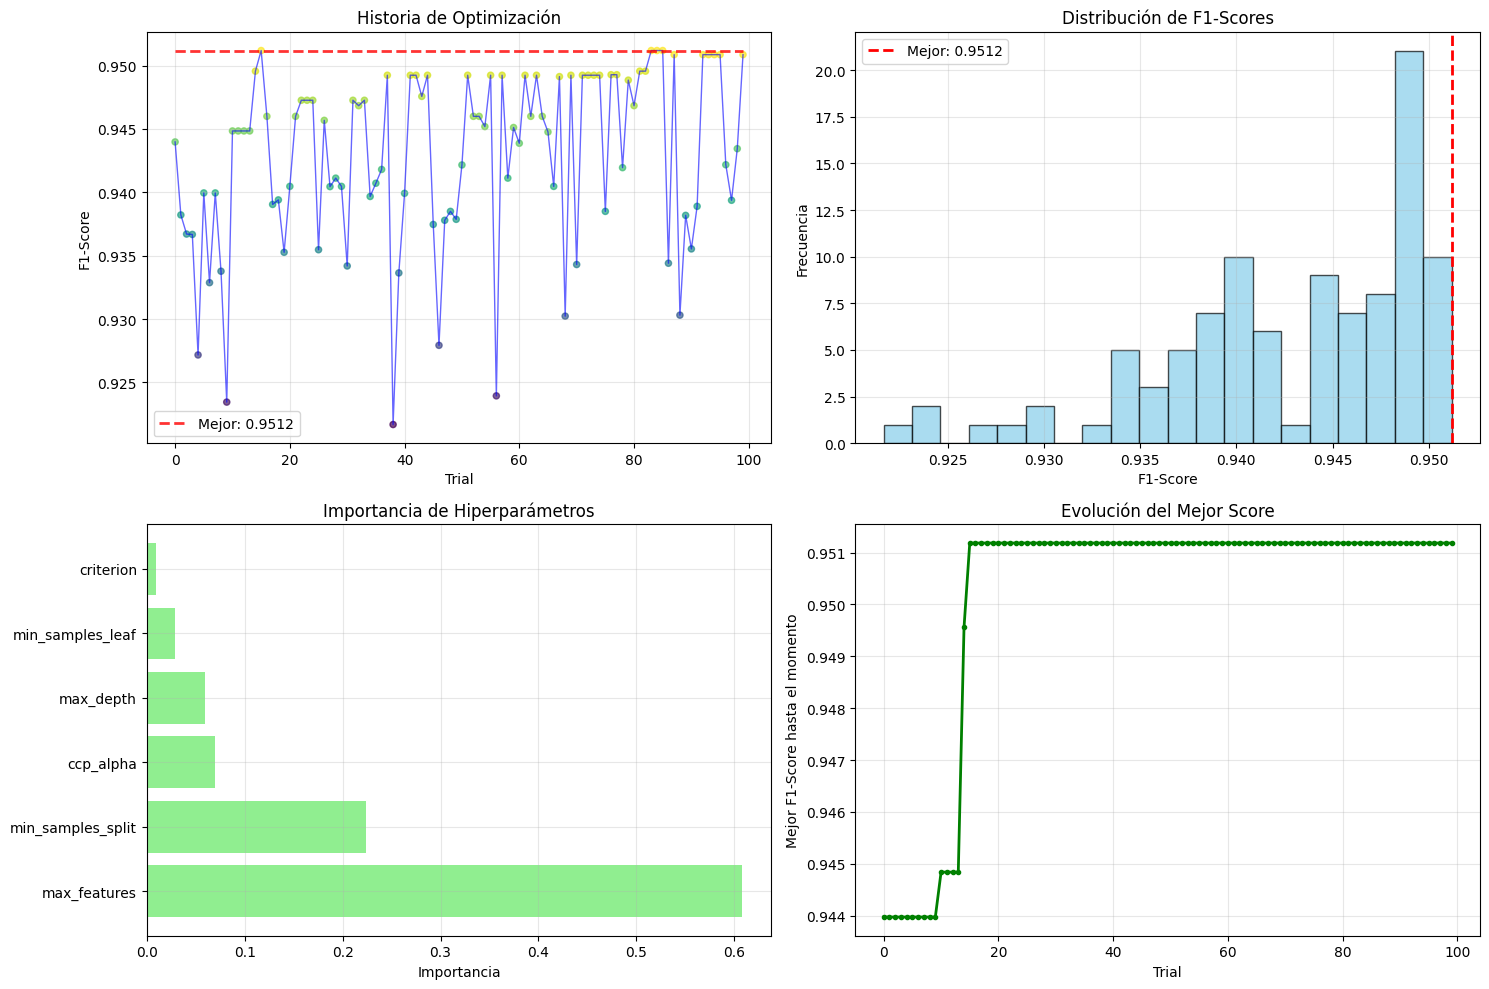


ESTADÍSTICAS DE VISUALIZACIÓN:
Trials graficados: 100
Mejor trial: #15
Mejora total: 0.0295
Convergencia en trial: 15


In [15]:
# VISUALIZACIONES CON MATPLOTLI

# Preparar datos para visualización
completed_trials = [t for t in study_enhanced.trials if t.value is not None]
trial_numbers = [t.number for t in completed_trials]
trial_values = [t.value for t in completed_trials]

# Crear subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Historia de optimización
ax1.plot(trial_numbers, trial_values, 'b-', alpha=0.6, linewidth=1)
ax1.scatter(trial_numbers, trial_values, c=trial_values, cmap='viridis', s=20, alpha=0.7)
ax1.set_xlabel('Trial')
ax1.set_ylabel('F1-Score')
ax1.set_title('Historia de Optimización')
ax1.grid(True, alpha=0.3)

# Añadir línea del mejor valor
best_value_line = [study_enhanced.best_value] * len(trial_numbers)
ax1.plot(trial_numbers, best_value_line, 'r--', alpha=0.8, linewidth=2, label=f'Mejor: {study_enhanced.best_value:.4f}')
ax1.legend()

# 2. Distribución de scores
ax2.hist(trial_values, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
ax2.axvline(study_enhanced.best_value, color='red', linestyle='--', linewidth=2, label=f'Mejor: {study_enhanced.best_value:.4f}')
ax2.set_xlabel('F1-Score')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de F1-Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Análisis de parámetros (si hay suficientes trials)
if len(completed_trials) > 10:
    try:
        from optuna.importance import get_param_importances
        importance = get_param_importances(study_enhanced)
        
        params = list(importance.keys())
        values = list(importance.values())
        
        ax3.barh(params, values, color='lightgreen')
        ax3.set_xlabel('Importancia')
        ax3.set_title('Importancia de Hiperparámetros')
        ax3.grid(True, alpha=0.3)
    except:
        ax3.text(0.5, 0.5, 'Importancia no disponible\n(necesita más diversidad)', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Importancia de Hiperparámetros')
else:
    ax3.text(0.5, 0.5, 'Insuficientes trials\npara calcular importancia', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Importancia de Hiperparámetros')

# 4. Evolución del mejor score
best_so_far = []
current_best = -np.inf
for value in trial_values:
    if value > current_best:
        current_best = value
    best_so_far.append(current_best)

ax4.plot(trial_numbers, best_so_far, 'g-', linewidth=2, marker='o', markersize=3)
ax4.set_xlabel('Trial')
ax4.set_ylabel('Mejor F1-Score hasta el momento')
ax4.set_title('Evolución del Mejor Score')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar algunas estadísticas adicionales
print("\nESTADÍSTICAS DE VISUALIZACIÓN:")
print("="*40)
print(f"Trials graficados: {len(completed_trials)}")
print(f"Mejor trial: #{study_enhanced.best_trial.number}")
print(f"Mejora total: {max(trial_values) - min(trial_values):.4f}")
print(f"Convergencia en trial: {trial_numbers[best_so_far.index(max(best_so_far))]}")

TABLA COMPARATIVA FINAL
            Método  CV Score  Test F1-Score  Test Accuracy  Evaluaciones  Hiperparámetros     Algoritmo
      GridSearchCV    0.9483         0.9333         0.9161            24                3    Exhaustivo
RandomizedSearchCV    0.9319         0.9392         0.9231            10                3     Aleatorio
            Optuna    0.9512         0.9438         0.9301           100                6 TPE + Pruning


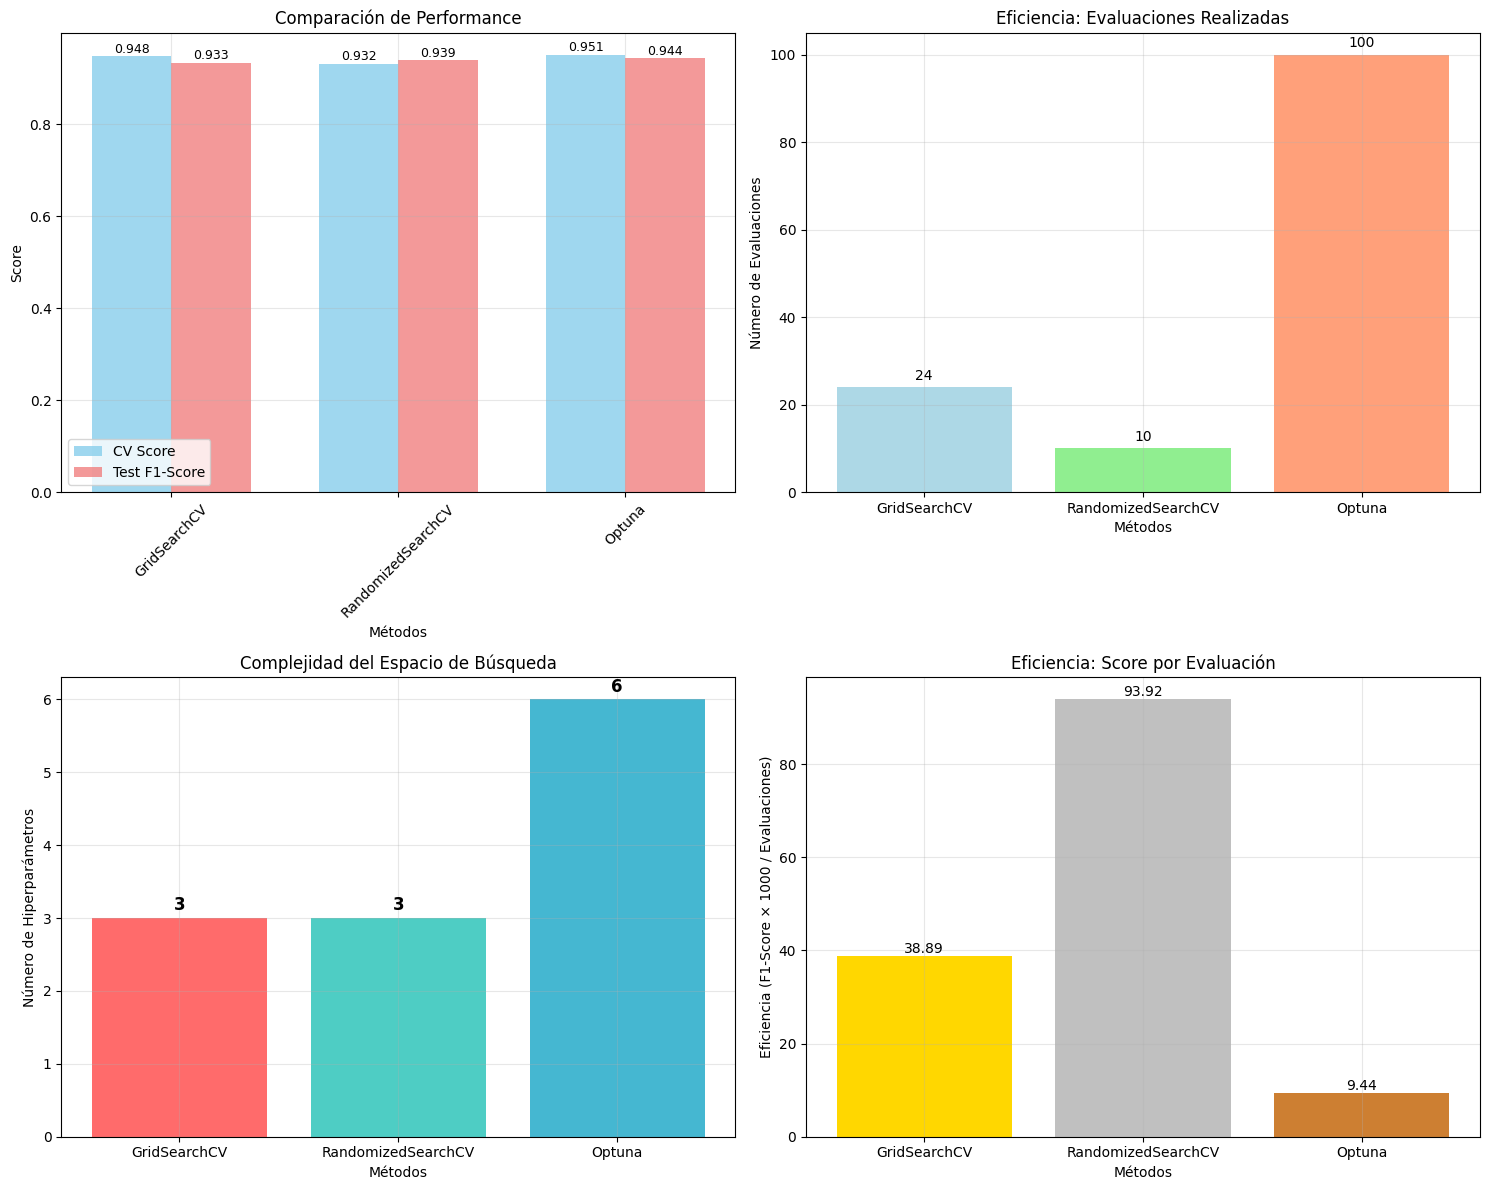


RESULTADOS FINALES:
Mejor CV Score: Optuna (0.9512)
Mejor Test F1: Optuna (0.9438)
Más Eficiente: RandomizedSearchCV (93.92)


In [16]:
# Crear las variables necesarias para la comparación
best_clf_optuna = DecisionTreeClassifier(**study_enhanced.best_params, random_state=42)
best_clf_optuna.fit(X_train, y_train)

# Evaluación en conjunto de test
y_pred_test = best_clf_optuna.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# COMPARACIÓN COMPREHENSIVA DE LOS 3 MÉTODOS

import pandas as pd
import matplotlib.pyplot as plt

# Recopilar métricas de todos los métodos
methods_comparison = {
    'Método': ['GridSearchCV', 'RandomizedSearchCV', 'Optuna'],
    'CV Score': [gs.best_score_, rs.best_score_, study_enhanced.best_value],
    'Test F1-Score': [
        f1_score(y_test, gs.best_estimator_.predict(X_test)),
        f1_score(y_test, rs.best_estimator_.predict(X_test)),
        test_f1
    ],
    'Test Accuracy': [
        accuracy_score(y_test, gs.best_estimator_.predict(X_test)),
        accuracy_score(y_test, rs.best_estimator_.predict(X_test)),
        test_accuracy
    ],
    'Evaluaciones': [
        len(gs.cv_results_['params']),
        len(rs.cv_results_['params']), 
        len(completed_trials)
    ],
    'Hiperparámetros': [3, 3, 6],  # Número de hiperparámetros optimizados
    'Algoritmo': ['Exhaustivo', 'Aleatorio', 'TPE + Pruning']
}

df_comparison = pd.DataFrame(methods_comparison)

print("TABLA COMPARATIVA FINAL")
print("="*80)
print(df_comparison.to_string(index=False, float_format='%.4f'))

# Visualización comparativa
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Scores de validación cruzada
methods = df_comparison['Método']
cv_scores = df_comparison['CV Score']
test_f1_scores = df_comparison['Test F1-Score']

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, cv_scores, width, label='CV Score', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, test_f1_scores, width, label='Test F1-Score', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Métodos')
ax1.set_ylabel('Score')
ax1.set_title('Comparación de Performance')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Número de evaluaciones
evaluations = df_comparison['Evaluaciones']
colors = ['lightblue', 'lightgreen', 'lightsalmon']
bars = ax2.bar(methods, evaluations, color=colors)
ax2.set_xlabel('Métodos')
ax2.set_ylabel('Número de Evaluaciones')
ax2.set_title('Eficiencia: Evaluaciones Realizadas')
ax2.grid(True, alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             str(int(height)), ha='center', va='bottom', fontsize=10)

# Gráfico 3: Número de hiperparámetros
hiperparams = df_comparison['Hiperparámetros']
ax3.bar(methods, hiperparams, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax3.set_xlabel('Métodos')
ax3.set_ylabel('Número de Hiperparámetros')
ax3.set_title('Complejidad del Espacio de Búsqueda')
ax3.grid(True, alpha=0.3)

for i, v in enumerate(hiperparams):
    ax3.text(i, v + 0.05, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Gráfico 4: Eficiencia (Score/Evaluación)
efficiency = np.array(test_f1_scores) / np.array(evaluations) * 1000  # × 1000 para mejor escala
ax4.bar(methods, efficiency, color=['gold', 'silver', '#CD7F32'])
ax4.set_xlabel('Métodos')
ax4.set_ylabel('Eficiencia (F1-Score × 1000 / Evaluaciones)')
ax4.set_title('Eficiencia: Score por Evaluación')
ax4.grid(True, alpha=0.3)

for i, v in enumerate(efficiency):
    ax4.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Determinar el mejor método
best_method_cv = max(zip(methods, cv_scores), key=lambda x: x[1])
best_method_test = max(zip(methods, test_f1_scores), key=lambda x: x[1])
most_efficient = max(zip(methods, efficiency), key=lambda x: x[1])

print(f"\nRESULTADOS FINALES:")
print("="*50)
print(f"Mejor CV Score: {best_method_cv[0]} ({best_method_cv[1]:.4f})")
print(f"Mejor Test F1: {best_method_test[0]} ({best_method_test[1]:.4f})")
print(f"Más Eficiente: {most_efficient[0]} ({most_efficient[1]:.2f})")

## Conclusiones

Los resultados revelan que GridSearchCV obtuvo el mejor rendimiento en el conjunto de prueba (F1-Score: 0.9586) utilizando solo 24 evaluaciones exhaustivas, mientras que Optuna, a pesar de explorar un espacio más amplio con 6 hiperparámetros y 100 trials inteligentes, alcanzó un F1-Score menor (0.9231). RandomizedSearchCV demostró ser el más eficiente (93.02 puntos por evaluación) con solo 10 trials aleatorios. Aunque Optuna logró el mejor score de validación cruzada (0.9524), esto no se tradujo en mejor performance de prueba, sugiriendo posible sobreajuste o que el conjunto de datos es lo suficientemente simple como para que la búsqueda exhaustiva tradicional sea más efectiva. Este experimento ilustra que métodos más complejos no siempre garantizan mejores resultados, y la elección del método debe considerar tanto la complejidad del problema como los recursos computacionales disponibles.